# Practical drift detection


## What is drift?

To look into what drift is, consider the somewhat generic setting that you have input data $X$ and (desired) output data $Y$. These are jointly distributed according to $P(X,Y)$. Also, we have a model $f : x \mapsto y$ which we hope maps $x$ to matching $y$ and has been optimized to minimize some loss $E_{P(X,Y)}[L(Y, m(X))]$.

Our setting has drifted when the distribution $P(X,Y)$ is different from a reference (e.g. during training) $P_{ref}(X,Y)$.

The literature (see e.g. S. Zhao et al.: A Review of Single-Source Deep Unsupervised Visual Domain Adaptation) distinguished between various drift (or shift, if you want to take a more static view) types

- Covariate or input drift: $P(Y | X) = P_{ref}(Y | X)$ but $P(X) \neq P_{ref}(X)$,
- Label drift: $P(X | Y) = P_{ref}(X | Y)$ but $P(Y) \neq P_{ref}(Y)$,
- Concept drift: $P(Y | X) \neq P_{ref}P(Y | X)$ (this differs from S. Zhao et al.).

These are not exclusive. For example, suppose we have a classifier between cats and dogs and now the class balance changes so that more inputs are actually dogs even though the cats and dogs by themselves look the same (in fancy-speak they have the same class-conditional distribution). By definition that is label drift. But it also is covariate drift because the more dog pictures we are seeing means that the input distribution has changed.

There are several things we would want to do that are related to drift: In _domain adaptation_ we try to make models which can cope with the new distribution $P$. In _drift detection_ (here) we are interested in detecting whether drift has happened. It will be hard to deal with concept drift because we typically do not have access to $Y$ from $P(Y)$, but we will see what can be done about the others.

In contrast to the drift detection we are concerned with, [outlier detection](https://en.wikipedia.org/wiki/Anomaly_detection) mainly investigates a single datapoint. The assessment then is whether it the observed datapoint is exceedingly improbable. The presence of outliers (in unexpected quantities) indicates a distribution shift, but the distribution shift may also consider an unexpected "narrowing" of the observation - in the extreme you may imagine suddenly only seeing the same perfectly normal example over and over again, this would not be an outlier, but certainly a drift. This assessment is possible because we work with a multiple samples from the test distribution at once. In fact, many of the statistical testing methods we apply below are essentially symmetric in the reference and the tested distribution.

## How do we detect drift?

When framed as above, drift detection is the question if $P(X,Y) \neq P_{ref}(X,Y)$. Given our setting, that we observe samples from $P(X,Y)$ or $P(X)$ after previously observing samples from $P_{ref}(X,Y)$, it is natural to look at statistical hypothsis for with the null hypothesis $P(X, Y) = P_{ref}(X,Y)$.

But there are several difficulties:

- We typically do not have $Y$ (e.g. the ground truth label) from $P$.
- The inputs $X$ typically are very high-dimensional - e.g. a 224x224 RGB picture is a 150'000 dimensional input.
  
  The curse of dimensionaly, this old nemesis of machine learning, makes directly testing with $X$ more or less infeasible.
  
So $X$ is all we have, and that is too high-dimensional to work with directly. But this means that we have to reduce the dimensionality. 

In summary,

- We typically need to work with $X$. We assume that we have a (sizeable) sample from $P_{ref}(X)$ and also get a sample from $P(X)$ to decide with.
- We need a way to reduce the dimensionality.
- We need a statistical test for $P = P_{ref}$.

We treat the first as a given and reflect a bit on the the other two parts.

## Dimension reduction

There are two main ways to do the dimension reduction.

An obvious choice might be to turn to estabilished methods for dimension reduction. There are plenty of them, the simplest is perhaps the principal component analysis (PCA). And indeed this is one of the routes we will take.

So what else can we do? Well, if the thing we are doing is, say, a classification problem, we had the same problem before: We wanted to have a class boundary but could not describe it on $X$ directly. Instead we trained our model function $m$.

But before we think we need to train a model for drift detection, we likely want to look at the one we already have, the model $m$ for our original task.

A typical model working on images might look like this:


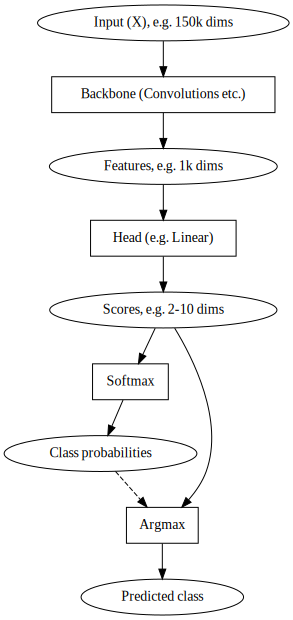

In [1]:
import graphviz
gr = graphviz.Digraph()
gr.node('inp','Input (X), e.g. 150k dims')
gr.node('bb', 'Backbone (Convolutions etc.)', shape='box')
gr.node('feat','Features, e.g. 1k dims')
gr.node('head', 'Head (e.g. Linear)', shape='box')
gr.node('score', 'Scores, e.g. 2-10 dims')
gr.node('softmax', 'Softmax', shape='box')
gr.node('probs', 'Class probabilities')
gr.node('argmax', 'Argmax', shape='box')
gr.node('class', 'Predicted class')
gr.edge('inp', 'bb')
gr.edge('bb', 'feat')
gr.edge('feat', 'head')
gr.edge('head', 'score')
gr.edge('score', 'softmax')
gr.edge('softmax', 'probs')
gr.edge('probs', 'argmax', style='dashed')
gr.edge('argmax', 'class')
gr.edge('score', 'argmax')
gr

Here, the model components are in boxes and the input, output and intermediate values are in ellipses.

If $X$ at the very top is not a good candidate, so we might use any other - the features, the scores, the class probabities or (at least we might conceptually) the predicted class.

But we could also avoid using the model $m$ for our task and replace it with another, e.g. a feature extractor trained in a self-supervised fashion or an a different task like ImageNet. One such auxilliary type of models that has been used are autoencoders.

There is a variant of this scheme where one uses an untrained model rather than a trained one, it is sometimes called the _Untrained AutoEncoder_ or _UAE_, making the more traditional autoencoder use alluded to above the _trained autoencoder_.

So this is how we might use a neural network for dimension reduction. Of course, we might also look at models beyond neural networks for this.

We have framed using a neural network as a method for merely reducing dimensions. This is an important aspect, but one might also hope that they can help in distinguishing meaningful drift from hypothetical change. The flip side, of course, is the danger that they might be "blind" to a change that we are interested in.

In other applications such as natural language processing (NLP), there is one other aspect of how neural networks work that we want to also use for the drift detection: Embedding layers help getting the inputs $X$ into a form that we can apply our drift detection mechanisms to.

In summary, dimension reduction is typically accomplished by

- an established dimension reduction method such as PCA,
- using a model, e.g. (parts of) the model for the original task.

Of course, we might also mix the two approaches — using a model first and then doing the last bit with the usual dimension reduction methods.

## Hypothesis testing and beyond

For the hypothesis testing we have samples $x^{ref}_1, ..., x^{ref}_N$ from $P_{ref}(X)$ and $x_1, ..., x_M$ from  $P$. Note that we don't expect these to actually be the raw inputs $X$ but we simplify our life here and ignore the dimension reduction / preprocessing in between. Each $x_i$ lies in $\mathbb{R^d}$, we assume that they are indepent. The null hypothesis is that the two distributions agree, i.e. $P = P_{ref}$.

We already see two important parameters here: The number $N$ of sample points from the reference and the number $M$ of sample points to be tested. As a rule of thumb, more samples help in more reliable testing, but we need to balance this with the compute requirement and, perhaps even more importantly, the time and cost of data acquisition. For the test data in particular, our desire to for timely monitoring may limit how many samples we want to wait for.

Now we have two types of tests:

- Some tests, such as the maximum mean discrepancy test ([A. Getton et al.: A Kernel Two-Sample Test, JMLR 2012](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html)) can be directly applied on the data for any $d$, even if
  large $d$ is undesirable.
- The most classical tests like the two-sample Kolmogorov-Smirnov test, are for one-dimensional data only.
  To use them, we must either reduce the dimensions to one in the dimension-reduction step of our drift detection 
  pipeline or we help ourselves with the kludge of just testing marginal distributions: We make $d$ 1-dimensional 
  tests if the marginal distribution of the $k$-th components of the samples of the vector-valued random variables 
  $X$ and  $X_{ref}$ are likely to have originated from distinct distributions.
  
  This loses power: First, the distribution might dramatically change while the marginals stay the same, and we would have no way to detect this change on the marginals. Secondly, we now make $d$ tests and if we wish to compute p-values, we need to [adjust for this](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). The (computationally, but not necessarily philosophically) simplest adjustment is a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), where we divide the significance level (the p-value) by $d$ and check if any test meets this harder significance criterion.

As the p-value gives us the expected rate of "false alarms" if the null hypotheses _no drift_ remains valid, just leaning on it does leave something to be desired in terms of calibrating detection rates. In many practical applications, we may not have samples of drifted data, so we have to make do with the p-value only. Typically we would choose rather low p-values. If we do have access to (potentially fabricated) samples from the drifted set, we can extend our analysis to consider the [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), so we can trade off the false positive rate against the statistical sensitivity of the detector. Examples of this analysis are provided in [drift detection on images](./drift_detection_on_images.ipynb).

We will discuss individual tests in [Comparing Drift Detectors](./comparing_drift_detectors.ipynb).

## Drift detection as classification

Another approach to the drift detection problem can be to try to classify samples into coming from $P_{ref}$ or $P$, respectively. If we cannot train a classifier that works better than random, we may conclude that $P_{ref}$ and $P$ are indistinguishable. This may sound very familiar, because it also is at the core of the Generative Adversarial Networks. It has also been used with great success for domain adaptation, where many methods use a train domain classifier as an auxiliary task and then minimize the ability to distinguish between source and target from the features used in the main task.

To make this operational, we can get out our toolbox of classifiers, e.g. Neural Networks and Nearest-Neighbor ones, see [D. Lopez-Paz, M. Oquab: Revisiting classifier two-sample tests, ICLR 2017](https://arxiv.org/abs/1610.06545). Note that this approach can be data-intensive: To execute, we need to split the samples $x^{ref}_i$ and $x_i$ into train and test samples. When using neural networks, we also need to train the classifier, adding computational requirements. When we have enough data and time, we may hope that such a classification-based approach may be highly effective.
